# Importing the required libraries

In [3]:
!rm -rf /kaggle/working/*

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten
from tensorflow.keras.applications import EfficientNetV2M

2024-05-19 13:41:33.211490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 13:41:33.211606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 13:41:33.335394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Flatten,MaxPooling2D,Conv2D,Activation
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import os
import glob

In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [7]:
encoder=OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4],[5]])

OneHotEncoder()

# Load the dataset

In [8]:
image_data='/kaggle/input/emotion-recognition-dataset/dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Surprise
1,Angry
2,Neutral
3,Sad
4,Happy
5,Ahegao


In [9]:
files_l = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files_l)
labels_l = [os.path.dirname(i).split("/")[-1] for i in files_l]
data_l = zip(files_l, labels_l)

In [10]:
dataframe_l = pd.DataFrame(data_l, columns = ["Image", "Label"])

In [11]:
print(dataframe_l )

                                                   Image     Label
0      /kaggle/input/emotion-recognition-dataset/data...     Happy
1      /kaggle/input/emotion-recognition-dataset/data...     Happy
2      /kaggle/input/emotion-recognition-dataset/data...    Ahegao
3      /kaggle/input/emotion-recognition-dataset/data...     Happy
4      /kaggle/input/emotion-recognition-dataset/data...    Ahegao
...                                                  ...       ...
15448  /kaggle/input/emotion-recognition-dataset/data...  Surprise
15449  /kaggle/input/emotion-recognition-dataset/data...   Neutral
15450  /kaggle/input/emotion-recognition-dataset/data...     Happy
15451  /kaggle/input/emotion-recognition-dataset/data...    Ahegao
15452  /kaggle/input/emotion-recognition-dataset/data...   Neutral

[15453 rows x 2 columns]


### To know the shape of the image

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
# Load the image
image_path = "/kaggle/input/emotion-recognition-dataset/dataset/Ahegao/cropped_emotions.16023~ahegao.png"

image = Image.open(image_path)

# Print the size of the image
print("Image size:", image.size)

Image size: (264, 382)


## Count the no.of images in each cateogary

In [13]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/input/emotion-recognition-dataset/dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Define an empty dictionary to store the counts of images for each class
class_counts = {}
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Surprise: 1234 images
Angry: 1313 images
Neutral: 4027 images
Sad: 3934 images
Happy: 3740 images
Ahegao: 1205 images
Total images: 15453


## Data visualisation

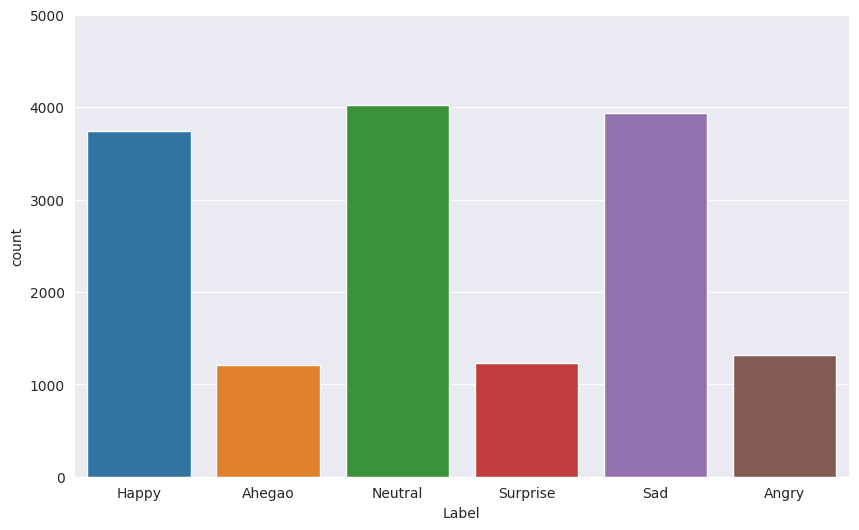

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=dataframe_l ["Label"])

# Get the counts for each class
class_counts = dataframe_l ["Label"].value_counts()
# Rotate x-axis labels if needed
plt.xticks(rotation=0)

# Limit y-axis range up to 6000
plt.ylim(0, 5000)

# Show plot
plt.show()

# Data Preprocessing

### Defining image parameter

In [15]:
image_data = '/kaggle/input/emotion-recognition-dataset/dataset'
train_data_dir = image_data
train_data_dir = image_data
batch_size = 64
target_size = (224, 224)
validation_split= 0.2

### Defineing augmentation parameters

In [16]:
augmentation_params = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Count images in each class

In [17]:
def count_images(class_name):
    class_path = os.path.join(train_data_dir, class_name)
    return len(os.listdir(class_path))

### Determining the classes to augment

In [18]:
classes_to_augment = ['Neutral','Sad','Happy','Ahegao', 'Angry', 'Surprise']
target_count = 4500

### Created an output directory

In [19]:
output_dir = '/kaggle/working/augmented_images'

### Performing data augmentation

In [20]:
for class_name in classes_to_augment:
    current_count = count_images(class_name)
    if current_count < target_count:
        augment_count = target_count - current_count
        augment_dir = os.path.join(output_dir, class_name)  # Save augmented images to a new directory
        os.makedirs(augment_dir, exist_ok=True)  # Create the directory if it doesn't exist
        augment_datagen = ImageDataGenerator(**augmentation_params)
        augment_generator = augment_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            classes=[class_name],
            save_to_dir=augment_dir,
            save_prefix='augmented',
            save_format='png'
        )
        # Generate augmented images until the target count is reached
        i = 0
        for batch in augment_generator:
            i += 1
            if i >= augment_count / batch_size:
                break

Found 4027 images belonging to 1 classes.
Found 3934 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 1205 images belonging to 1 classes.
Found 1313 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.


### Count of augmented images

In [21]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/working/augmented_images'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")


Neutral: 512 images
Sad: 576 images
Happy: 768 images
Angry: 3138 images
Surprise: 3236 images
Ahegao: 3306 images
Total images: 11536


## Combining original images and augmented images

In [22]:
import os
import shutil

# Define paths
original_data_path ='/kaggle/input/emotion-recognition-dataset/dataset'
augmented_data_path = '/kaggle/working/augmented_images'
new_data_path = '/kaggle/working/merged_dataset'

# Get the list of classes
classes = os.listdir(original_data_path)
classes

['Surprise', 'Angry', 'Neutral', 'Sad', 'Happy', 'Ahegao']

In [23]:
# Create directories for each class in the new data path
for class_name in classes:
    os.makedirs(os.path.join(new_data_path, class_name), exist_ok=True)

# Copy images from the original data path to the new data path
for class_name in classes:
    original_class_path = os.path.join(original_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(original_class_path):
        shutil.copy(os.path.join(original_class_path, filename), os.path.join(new_class_path, filename))

# Copy images from the augmented data path to the new data path
for class_name in classes:
    augmented_class_path = os.path.join(augmented_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(augmented_class_path):
        shutil.copy(os.path.join(augmented_class_path, filename), os.path.join(new_class_path, filename))

print("Data merge complete.")


Data merge complete.


## Count of combined images

In [26]:
# Define the directory containing the dataset
merged_dataset = '/kaggle/working/merged_dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(merged_dataset) if os.path.isdir(os.path.join(merged_dataset, d))]

# Iterate through each class directory and count the number of files
class_count={}
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(merged_dataset, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Neutral: 4539 images
Sad: 4510 images
Happy: 4508 images
Angry: 4451 images
Surprise: 4470 images
Ahegao: 4511 images
Total images: 26989


In [31]:

import os
import matplotlib.pyplot as plt

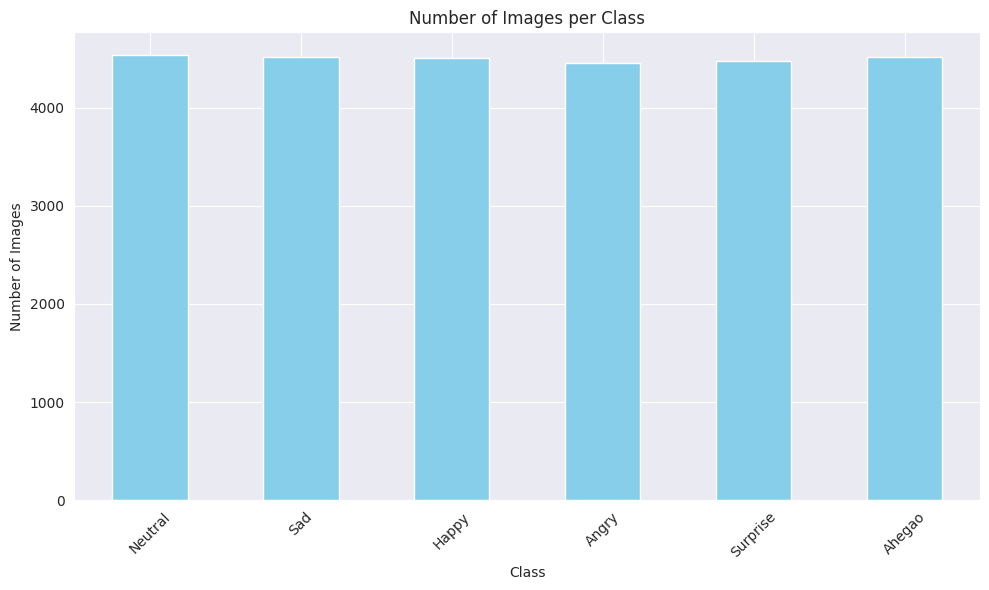

In [39]:
# Assuming class_counts is a pandas Series
class_counts = pd.Series({'Neutral': 4539, 'Sad': 4510, 'Happy': 4508, 'Angry': 4451, 'Surprise': 4470, 'Ahegao': 4511})

# Plotting the bar graph
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
import os
import shutil

# Define the source directory and the destination zip file path
source_dir = '/kaggle/working/merged_dataset'
output_zip_path = '/kaggle/working/augmented_merged_dataset.zip'

# Check if the source directory exists
if os.path.exists(source_dir):
    # Create the zip file
    shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', source_dir)
    print(f"Directory '{source_dir}' zipped successfully.")
else:
    print(f"Source directory '{source_dir}' does not exist.")

Directory '/kaggle/working/merged_dataset' zipped successfully.


# Download the augmented images